# Tomato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Importing

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

### Constants

In [2]:
IMAGE_SIZE = 190      
CHANNELS=3
BATCH_SIZE = 32

### Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato",                         # directory name
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)  # Found 16011 files belonging to 10 classes.

Found 16011 files belonging to 10 classes.


In [4]:
len(dataset)                          # images are in 501 batch of each 30 {  30*534 = 16011 approx}

501

### Visualization

In [5]:
class_names = dataset.class_names            # folder class names 
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

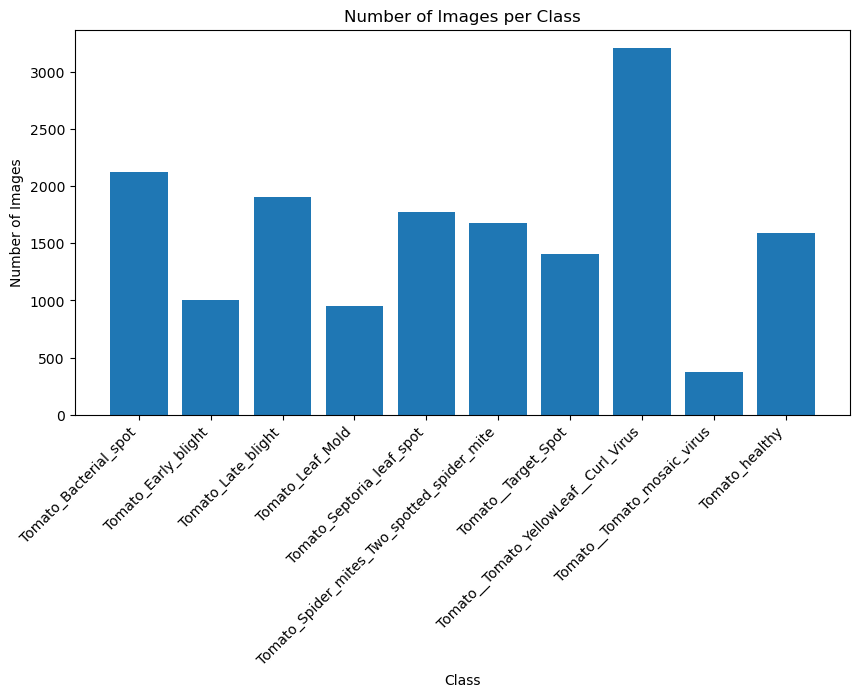

In [6]:
# Count the number of images per class
num_images_per_class = [0] * len(class_names)
for images, labels in dataset:
    for label in labels:
        num_images_per_class[label] += 1

# Plot the bar graph
plt.figure(figsize=(10, 5))
plt.bar(class_names, num_images_per_class)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45, ha='right')
plt.show()

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)       #(    32,      256, 256,3           )        batch has 32 images of shape(256,256 ,3) each
                              #         images     shape of each image

    print(labels_batch.numpy())     # gives classes 0 1 2 of all images in 1st batch of 32

(32, 190, 190, 3)
[4 7 4 7 9 7 7 6 6 7 2 6 7 8 1 4 4 2 5 5 7 0 4 3 0 2 9 2 1 5 9 2]


[[[139.5353   132.5353   139.5353  ]
  [123.38319  116.38319  123.38319 ]
  [138.78864  131.78864  138.78864 ]
  ...
  [121.22434  112.22434  115.22434 ]
  [110.72196  101.72196  104.72196 ]
  [122.018974 113.018974 116.018974]]

 [[137.82939  130.82939  137.82939 ]
  [135.63513  128.63513  135.63513 ]
  [140.55196  133.55196  140.55196 ]
  ...
  [121.77964  112.77964  115.77964 ]
  [110.650406 101.650406 104.650406]
  [110.794624 101.794624 104.794624]]

 [[136.59363  129.59363  136.59363 ]
  [129.79932  122.79931  129.79932 ]
  [155.03947  148.03947  155.03947 ]
  ...
  [123.70213  114.70213  117.70213 ]
  [117.59514  108.59514  111.59514 ]
  [119.738815 110.738815 113.738815]]

 ...

 [[145.9673   136.9673   139.9673  ]
  [147.54808  138.54808  141.54808 ]
  [144.83109  135.83109  138.83109 ]
  ...
  [114.34283  105.34283  108.34283 ]
  [116.93165  107.93165  110.93165 ]
  [113.03674  104.03674  107.03674 ]]

 [[138.39897  129.39897  132.39897 ]
  [155.70781  146.70781  149.70781 ]


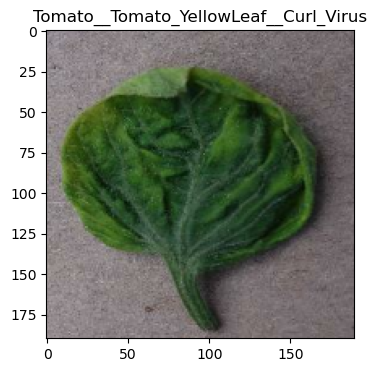

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())      # 1st image of 1st batch 

    plt.figure(figsize=(4, 4))
    plt.title(class_names[labels_batch[0]]) # label of class
    plt.imshow(image_batch[0].numpy().astype("uint8"))      # 1st image of batch
    #plt.axis("off")           to remove measures

More images

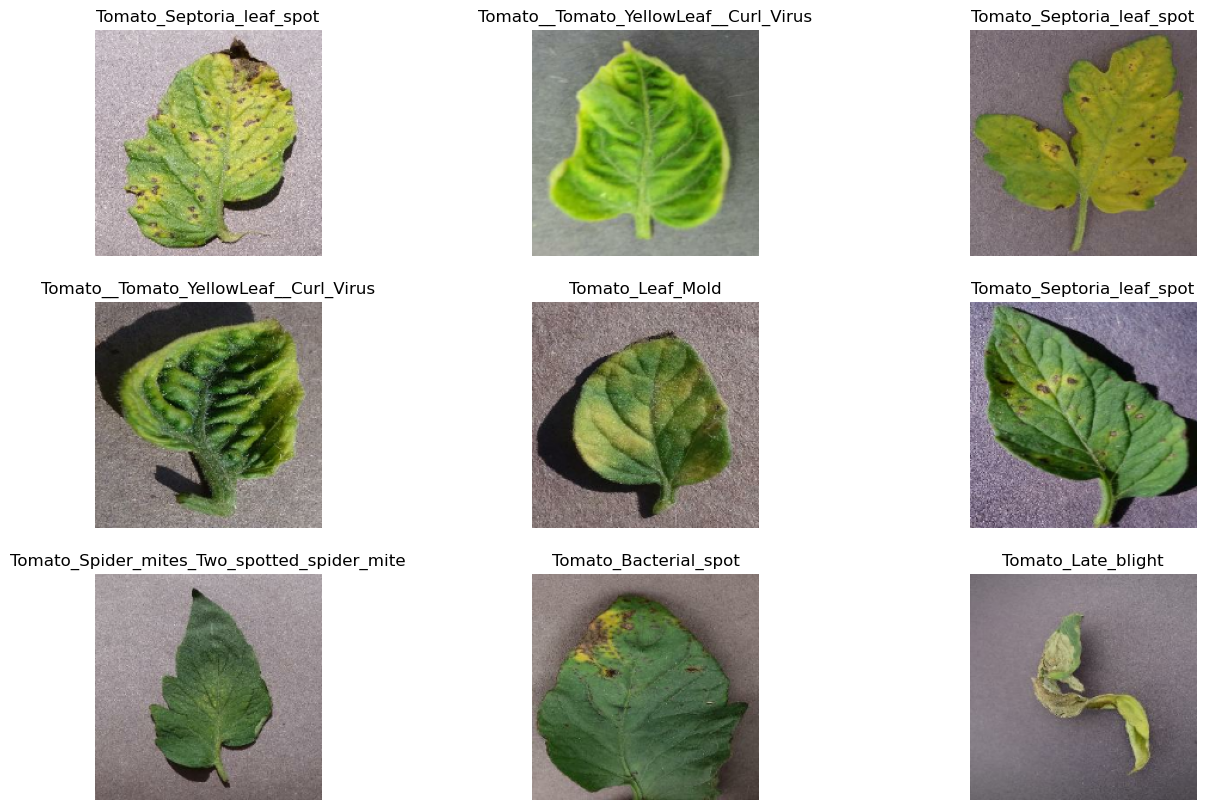

In [9]:
plt.figure(figsize=(16, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset
1. 80% training
2. 10% validation for each epoch
3. 10% test

In [10]:
# fn for above splitting
def data_splitting(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds,test_ds = data_splitting(dataset)       #batches splitting


In [12]:
len(train_ds)

400

In [13]:
len(val_ds)

50

In [14]:
len(test_ds)

51

### Cache, Shuffle, and Prefetch the Dataset

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Augmentation

In [16]:
data_augmentation1 = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
data_augmentation2 = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.8),
])

Applying Data Augmentation to Train Dataset

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation1(x, training=True), y)        ).prefetch(buffer_size=tf.data.AUTOTUNE)
#                 function

In [19]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation2(x, training=True), y)        ).prefetch(buffer_size=tf.data.AUTOTUNE)
#                 function

### Resize and rescale

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Model Architecture

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)  #4


model = models.Sequential(
    [ 
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 190, 190, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 188, 188, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 94, 94, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 94, 94, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 47, 47, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 47, 47, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
EPOCHS=50
with tf.device('/GPU:0'):
    epoch_details = model.fit(
                            train_ds,
                            batch_size=BATCH_SIZE,
                            validation_data=val_ds,
                            verbose=1,
                            epochs=EPOCHS,
                        )

Epoch 1/50
400/400 [==============================] - 145s 249ms/step - loss: 1.7476 - accuracy: 0.3768 - val_loss: 1.4880 - val_accuracy: 0.4600
Epoch 2/50
400/400 [==============================] - 71s 178ms/step - loss: 1.1804 - accuracy: 0.5971 - val_loss: 1.0092 - val_accuracy: 0.6625
Epoch 3/50
400/400 [==============================] - 79s 197ms/step - loss: 0.8624 - accuracy: 0.7053 - val_loss: 0.6396 - val_accuracy: 0.7663
Epoch 4/50
400/400 [==============================] - 85s 211ms/step - loss: 0.7049 - accuracy: 0.7566 - val_loss: 0.4885 - val_accuracy: 0.8188
Epoch 5/50
400/400 [==============================] - 85s 212ms/step - loss: 0.6237 - accuracy: 0.7879 - val_loss: 0.4565 - val_accuracy: 0.8325
Epoch 6/50
400/400 [==============================] - 81s 202ms/step - loss: 0.5765 - accuracy: 0.8040 - val_loss: 0.4105 - val_accuracy: 0.8537
Epoch 7/50
400/400 [==============================] - 80s 199ms/step - loss: 0.5278 - accuracy: 0.8261 - val_loss: 0.3943 - val_a

In [24]:
model.evaluate(test_ds)

51/51 [==============================] - 47s 72ms/step - loss: 0.1335 - accuracy: 0.9559


[0.1334526240825653, 0.9558823704719543]

### Accuracy and Loss Curves

In [25]:
epoch_details.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
epoch_details.history['loss'][:5] # show loss for first 5 epochs

[1.7476048469543457,
 1.1803656816482544,
 0.8624106049537659,
 0.7049064040184021,
 0.6237367391586304]

In [27]:
acc = epoch_details.history['accuracy']
val_acc = epoch_details.history['val_accuracy']

loss = epoch_details.history['loss']
val_loss = epoch_details.history['val_loss']

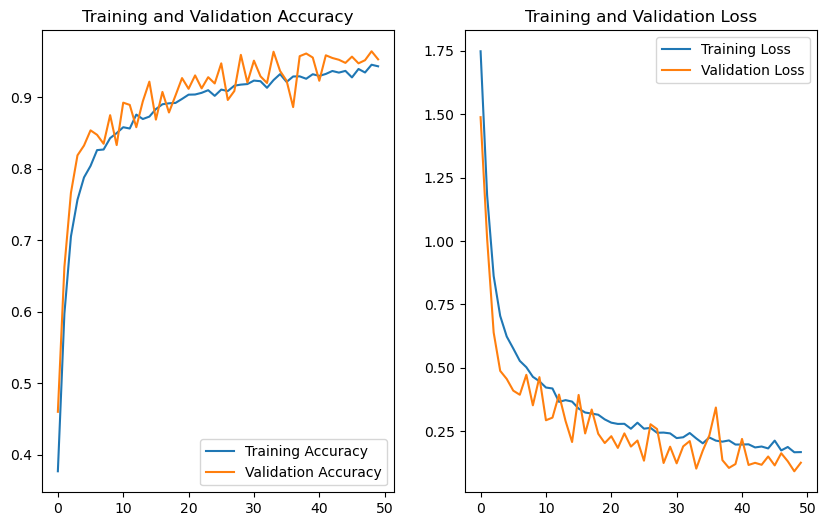

In [28]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction

In [92]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

##### Prediction on sample images

1/1 [==============================] - 0s 38ms/step


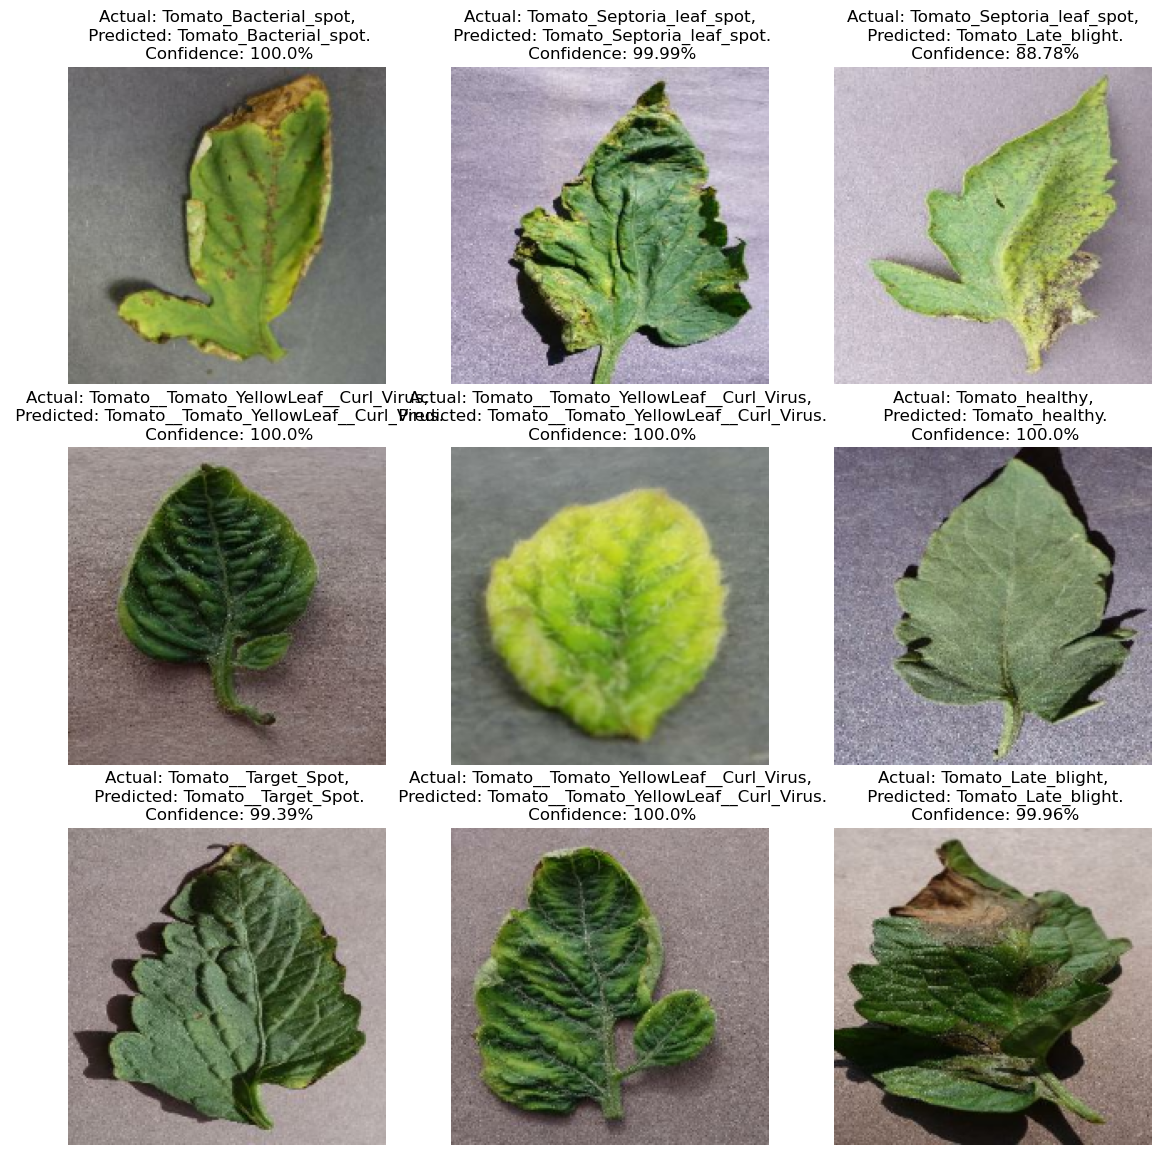

In [93]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [102]:
y_pred_test=[]
y_test=[]
for images, labels in test_ds:
    for i in range(len(images)):
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        y_pred_test.append(predicted_class)
        y_test.append(actual_class)


1/1 [==============================] - 0s 22ms/step


In [103]:
y_pred_test[:5]

['Tomato_Bacterial_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Septoria_leaf_spot']

In [104]:
y_test[:5]

['Tomato_Bacterial_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Septoria_leaf_spot']

In [105]:
print(len(y_pred_test))
print(len(y_test))

1632
1632


                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       1.00      0.95      0.97       221
                        Tomato_Early_blight       0.83      0.93      0.88       107
                         Tomato_Late_blight       0.93      0.95      0.94       214
                           Tomato_Leaf_Mold       0.96      0.89      0.92        90
                  Tomato_Septoria_leaf_spot       0.94      0.95      0.94       190
Tomato_Spider_mites_Two_spotted_spider_mite       0.98      0.95      0.96       170
                        Tomato__Target_Spot       0.95      0.93      0.94       130
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.98      1.00      0.99       319
                Tomato__Tomato_mosaic_virus       0.89      0.89      0.89        37
                             Tomato_healthy       0.99      1.00      0.99       154

                                   accuracy                    

Text(95.72222222222221, 0.5, 'Truth')

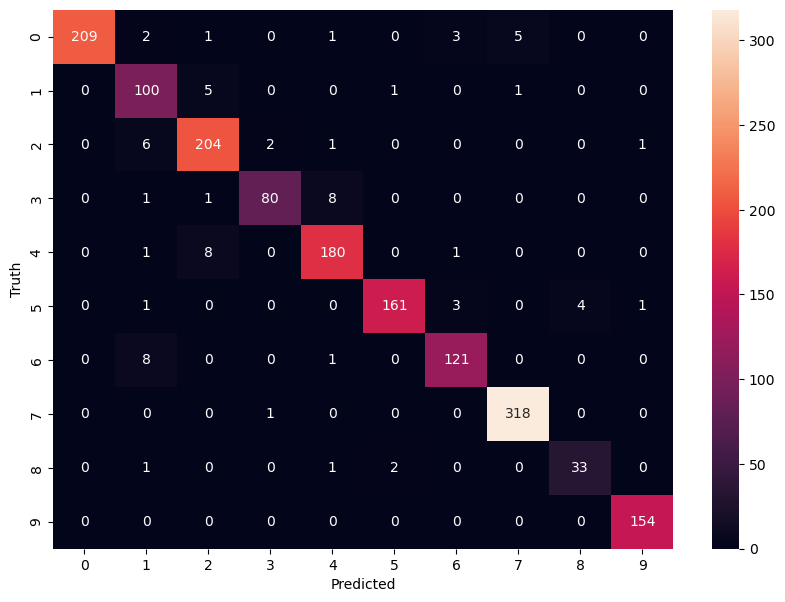

In [106]:
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sn

print(classification_report(y_test,y_pred_test))
cm = confusion_matrix(y_test,y_pred_test)

#   import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Saving the Model

In [32]:
model.save("tomato.h5")